# Ablation 2: Migrating from pytorch-pretrained-bert to Transformers

In the original implementation of ClinicalBERT, Huang et al. rely on pytorch-pretrained-bert, the PyTorch version of Google AI BERT model with script to load Google pre-trained models. See https://pypi.org/project/pytorch-pretrained-bert/ for more information.

We decided to run a secondary ablation - migrate from the pytorch-pretrained-bert library to using the more sophisticated Transformers library - and see if there would be any performance improvements in terms of accuracy or computational complexity (ie. runtime).

Transformers is a library of over 32 state-of-the-art pre-trained models for natural language processing. We updated our ClinicalBERT model with Transformers, reimplementing the forward method to always output a tuple with encoded layers and pooled output. The two optimizers---BertAdam and OpenAIAdam---have been replaced by a single AdamW optimizer, so we replaced BertAdam with AdamW, following the same decay schedule.

We ran 3 independent trials, with a batch size of 3, learning rate of 0.00005, hidden size of 768, and dropout rate of 0.1. Table 7 reveals that while our reproduced ClinicalBERT had a combined runtime of 9h26m for both experiment, the ablations with adding Transformers resulted in a 84% decrease to 1h28m. Table 1 and 2 also reveal the AUROC and AUPRC values of reproduced and modified ClinicalBERT models, on discharge and early clinical notes, are within a 1% margin of each other. Given the lower compute time and higher AUROC and AUPRC for both tasks, these findings reinforce Huang et al.’s speculation and our hypothesis that finetuning may yield better performance.

## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm, trange
import pickle
import torch
from torch import nn
import random
import logging
import os
import sys
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from modeling_readmission import BertForSequenceClassification
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
from funcsigs import signature
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

## Load and Preprocess Data

In [5]:
df_adm = pd.read_csv('./physionet.org/files/mimiciii/1.4/ADMISSIONS.csv')

In [6]:
df_notes=pd.read_csv('./physionet.org/files/mimiciii/1.4/NOTEEVENTS.csv')

/var/folders/rx/lt7qchz54wlcnz8s602v0kn80000gn/T/ipykernel_8941/2760791028.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_notes=pd.read_csv('./physionet.org/files/mimiciii/1.4/NOTEEVENTS.csv')


### Admissions.CSV

In [7]:
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_adm = df_adm.sort_values(['SUBJECT_ID', 'ADMITTIME'])
df_adm = df_adm.reset_index(drop=True)
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')
df_adm['DAYS_NEXT_ADMIT'] = (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)
df_adm = df_adm.loc[df_adm.ADMISSION_TYPE != 'NEWBORN']
df_adm = df_adm.loc[df_adm.DEATHTIME.isnull()]
df_adm['OUTPUT_LABEL'] = (df_adm.DAYS_NEXT_ADMIT < 30).astype('int')
df_adm['DURATION'] = (df_adm['DISCHTIME']-df_adm['ADMITTIME']).dt.total_seconds()/(24*60*60)

In [8]:
df_adm

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,OUTPUT_LABEL,DURATION
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaT,NaN,NaN,0,10.784722
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaT,NaN,NaN,0,7.759028
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaT,NaN,NaN,0,16.364583
9,10,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,...,2178-04-15 20:46:00,2178-04-16 06:53:00,BRAIN MASS,0,1,NaT,NaN,NaN,0,25.529167
11,12,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,...,NaN,NaN,CORONARY ARTERY DISEASE,0,1,NaT,NaN,NaN,0,6.855556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58972,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,...,2181-01-26 23:35:00,2181-01-27 04:18:00,FEVER,0,1,NaT,NaN,NaN,0,16.595833
58972,58973,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NaN,NaN,DIVERTICULITIS/SDA,0,1,NaT,NaN,NaN,0,12.156250
58973,58974,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,...,2144-07-25 13:40:00,2144-07-25 18:50:00,RETROPERITONEAL HEMORRHAGE,0,1,NaT,NaN,NaN,0,2.995139
58974,58975,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicare,...,NaN,NaN,ABDOMINAL AORTIC ANEURYSM/SDA,0,1,NaT,NaN,NaN,0,3.218750


### NOTEEVENTS.CSV

For discharge summaries

In [9]:
df_notes = df_notes.sort_values(by=['SUBJECT_ID','HADM_ID','CHARTDATE'])
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME','OUTPUT_LABEL','DURATION']],
                        df_notes[['SUBJECT_ID','HADM_ID','CHARTDATE','TEXT','CATEGORY']],
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
df_adm_notes.ADMITTIME_C = df_adm_notes.ADMITTIME.apply(lambda x: str(x).split(' ')[0])

df_adm_notes['ADMITTIME_C'] = pd.to_datetime(df_adm_notes.ADMITTIME_C, format = '%Y-%m-%d', errors = 'coerce')
df_adm_notes['CHARTDATE'] = pd.to_datetime(df_adm_notes.CHARTDATE, format = '%Y-%m-%d', errors = 'coerce')
df_discharge = df_adm_notes[df_adm_notes['CATEGORY'] == 'Discharge summary']
df_discharge = (df_discharge.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
df_discharge = df_discharge[df_discharge['TEXT'].notnull()]

/var/folders/rx/lt7qchz54wlcnz8s602v0kn80000gn/T/ipykernel_8941/2636703041.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_adm_notes.ADMITTIME_C = df_adm_notes.ADMITTIME.apply(lambda x: str(x).split(' ')[0])


In [10]:
df_discharge

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,OUTPUT_LABEL,DURATION,CHARTDATE,TEXT,CATEGORY,ADMITTIME_C
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,NaT,EMERGENCY,NaT,0,10.784722,2101-10-31,Admission Date: [**2101-10-20**] Discharg...,Discharge summary,2101-10-20
1,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,NaT,EMERGENCY,NaT,0,7.759028,2191-03-23,Admission Date: [**2191-3-16**] Discharge...,Discharge summary,2191-03-16
2,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,NaT,ELECTIVE,NaT,0,16.364583,2175-06-15,Admission Date: [**2175-5-30**] Dischar...,Discharge summary,2175-05-30
3,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,NaT,EMERGENCY,NaT,0,25.529167,2178-05-11,Admission Date: [**2178-4-16**] ...,Discharge summary,2178-04-16
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,NaT,EMERGENCY,NaT,0,6.855556,2167-01-15,"Name: [**Known lastname 9900**], [**Known fir...",Discharge summary,2167-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43875,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,NaN,NaT,EMERGENCY,NaT,0,16.595833,2181-02-12,Admission Date: [**2181-1-27**] ...,Discharge summary,2181-01-27
43876,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,NaN,NaT,ELECTIVE,NaT,0,12.156250,2185-01-05,Admission Date: [**2184-12-24**] ...,Discharge summary,2184-12-24
43877,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,NaN,NaT,EMERGENCY,NaT,0,2.995139,2144-07-28,Admission Date: [**2144-7-25**] ...,Discharge summary,2144-07-25
43878,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,NaN,NaT,ELECTIVE,NaT,0,3.218750,2147-02-11,Admission Date: [**2147-2-8**] D...,Discharge summary,2147-02-08


For clinical notes

In [11]:
def less_n_days_data(df_adm_notes, n):
    df_less_n = df_adm_notes[
        ((df_adm_notes['CHARTDATE'] - df_adm_notes['ADMITTIME_C']).dt.total_seconds() / (24 * 60 * 60)) < n]
    df_less_n = df_less_n[df_less_n['TEXT'].notnull()]
    df_concat = pd.DataFrame(df_less_n.groupby('HADM_ID')['TEXT'].apply(lambda x: "%s" % ' '.join(x))).reset_index()
    df_concat['OUTPUT_LABEL'] = df_concat['HADM_ID'].apply(
        lambda x: df_less_n[df_less_n['HADM_ID'] == x].OUTPUT_LABEL.values[0])
    
    return df_concat

df_less_2 = less_n_days_data(df_adm_notes, 2)
df_less_3 = less_n_days_data(df_adm_notes, 3)

In [12]:
def preprocessing(df_less_n):
    def preprocess(x):
        y = re.sub('\\[(.*?)\\]', '', x)
        y = re.sub('[0-9]+\.', '', y)  
        y = re.sub('dr\.', 'doctor', y)
        y = re.sub('m\.d\.', 'md', y)
        y = re.sub('admission date:', '', y)
        y = re.sub('discharge date:', '', y)
        y = re.sub('--|__|==', '', y)
        return y

    df_less_n['TEXT'] = df_less_n['TEXT'].fillna(' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\n', ' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].str.replace('\r', ' ')
    df_less_n['TEXT'] = df_less_n['TEXT'].apply(str.strip)
    df_less_n['TEXT'] = df_less_n['TEXT'].str.lower()

    df_less_n['TEXT'] = df_less_n['TEXT'].apply(lambda x: preprocess1(x))

    # to get 318 words chunks for readmission tasks
    df_len = len(df_less_n)
    want = pd.DataFrame({'ID': [], 'TEXT': [], 'Label': []})
    for i in tqdm(range(df_len)):
        x = df_less_n.TEXT.iloc[i].split()
        n = int(len(x) / 318)
        for j in range(n):
            want = want.append({'TEXT': ' '.join(x[j * 318:(j + 1) * 318]), 'Label': df_less_n.OUTPUT_LABEL.iloc[i],
                                'ID': df_less_n.HADM_ID.iloc[i]}, ignore_index=True)
        if len(x) % 318 > 10:
            want = want.append({'TEXT': ' '.join(x[-(len(x) % 318):]), 'Label': df_less_n.OUTPUT_LABEL.iloc[i],
                                'ID': df_less_n.HADM_ID.iloc[i]}, ignore_index=True)

    return want

In [13]:
# df_discharge = preprocessing(df_discharge)
# df_less_2 = preprocessing(df_less_2)
# df_less_3 = preprocessing(df_less_3)

In [14]:
# df_discharge.to_pickle("ablation_models/updated_transformer/df_discharge.pkl")
# df_less_2.to_pickle("ablation_models/updated_transformer/df_2days.pkl")
# df_less_3.to_pickle("ablation_models/updated_transformer/df_3days.pkl")

In [15]:
df_discharge = pd.read_pickle('./ablation_models/updated_transformer/df_discharge.pkl')
df_less_2 = pd.read_pickle('./ablation_models/updated_transformer/df_2days.pkl')
df_less_3 = pd.read_pickle('./ablation_models/updated_transformer/df_3days.pkl')

In [16]:
print(df_discharge.shape, df_less_2.shape, df_less_3.shape)

(216954, 3) (277443, 3) (385724, 3)


## Create Train/Val/Test Splits

In [17]:
readmit_ID = df_adm[df_adm.OUTPUT_LABEL == 1].HADM_ID
not_readmit_ID = df_adm[df_adm.OUTPUT_LABEL == 0].HADM_ID
not_readmit_ID_use = not_readmit_ID.sample(n=len(readmit_ID), random_state=1)
id_val_test_t = readmit_ID.sample(frac=0.2, random_state=1)
id_val_test_f = not_readmit_ID_use.sample(frac=0.2, random_state=1)

id_train_t = readmit_ID.drop(id_val_test_t.index)
id_train_f = not_readmit_ID_use.drop(id_val_test_f.index)

id_val_t = id_val_test_t.sample(frac=0.5, random_state=1)
id_test_t = id_val_test_t.drop(id_val_t.index)

id_val_f = id_val_test_f.sample(frac=0.5, random_state=1)
id_test_f = id_val_test_f.drop(id_val_f.index)

id_test = pd.concat([id_test_t, id_test_f])
test_id_label = pd.DataFrame(data=list(zip(id_test, [1] * len(id_test_t) + [0] * len(id_test_f))),
                             columns=['id', 'label'])

id_val = pd.concat([id_val_t, id_val_f])
val_id_label = pd.DataFrame(data=list(zip(id_val, [1] * len(id_val_t) + [0] * len(id_val_f))), columns=['id', 'label'])

id_train = pd.concat([id_train_t, id_train_f])
train_id_label = pd.DataFrame(data=list(zip(id_train, [1] * len(id_train_t) + [0] * len(id_train_f))),
                              columns=['id', 'label'])

In [18]:
discharge_train = df_discharge[df_discharge.ID.isin(train_id_label.id)]
discharge_val = df_discharge[df_discharge.ID.isin(val_id_label.id)]
discharge_test = df_discharge[df_discharge.ID.isin(test_id_label.id)]

### For Discharge Summaries

In [19]:
df = pd.concat([not_readmit_ID_use, not_readmit_ID])
df = df.drop_duplicates(keep=False)
(pd.Index(df).intersection(pd.Index(not_readmit_ID_use))).values

not_readmit_ID_more = df.sample(n=400, random_state=1)

discharge_train_snippets = pd.concat([df_discharge[df_discharge.ID.isin(not_readmit_ID_more)], discharge_train])
discharge_train_snippets = discharge_train_snippets.sample(frac=1, random_state=1).reset_index(drop=True)
discharge_train_snippets.Label.value_counts()
discharge_train_snippets.to_csv('./data/discharge/train.csv')
discharge_val.to_csv('./data/discharge/val.csv')
discharge_test.to_csv('./data/discharge/test.csv')

### For Early Clinical Notes - 3 days

In [20]:
early_train = df_less_3[df_less_3.ID.isin(train_id_label.id)]
not_readmit_ID_more = df.sample(n=500, random_state=1)
early_train_snippets = pd.concat([df_less_3[df_less_3.ID.isin(not_readmit_ID_more)], early_train])
early_train_snippets = early_train_snippets.sample(frac=1, random_state=1).reset_index(drop=True)
early_train_snippets.to_csv('./data/3days/train.csv')

early_val = df_less_3[df_less_3.ID.isin(val_id_label.id)]
early_val.to_csv('./data/3days/val.csv')

actionable_ID_3days = df_adm[df_adm['DURATION'] >= 3].HADM_ID
test_actionable_id_label = test_id_label[test_id_label.id.isin(actionable_ID_3days)]
early_test = df_less_3[df_less_3.ID.isin(test_actionable_id_label.id)]

early_test.to_csv('./data/3days/test.csv')

### For Early Clinical Notes - 2 days

In [21]:
actionable_ID_2days = df_adm[df_adm['DURATION'] >= 2].HADM_ID
test_actionable_id_label_2days = test_id_label[test_id_label.id.isin(actionable_ID_2days)]
early_test_2days = df_less_2[df_less_2.ID.isin(test_actionable_id_label_2days.id)]
early_test_2days.to_csv('./data/2days/test.csv')

## Early Notes

### Run Model for Readmission Prediction

In [23]:
local_rank = -1
no_cuda = False # Set flag to True to disable CUDA
if local_rank == -1 or no_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    device = torch.device("cuda", local_rank)
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)
logger.info("device: %s n_gpu: %d Distributed training: %r", device, n_gpu, bool(local_rank != -1))

04/15/2022 21:14:00 - INFO - __main__ -   device: cpu n_gpu: 0 Distributed training: False


In [25]:
gradient_accumulation_steps = 1
if gradient_accumulation_steps < 1:
    raise ValueError("Invalid gradient_accumulation_steps parameter: {}, should be >= 1".format(gradient_accumulation_steps))

train_batch_size = 32
train_batch_size = int(train_batch_size / gradient_accumulation_steps)
seed= 42
do_train = False
do_eval = True
output_dir = './results/ablation/transformer/result_early' 

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

if not do_train and not do_eval:
    raise ValueError("At least one of `do_train` or `do_eval` must be True.")

if os.path.exists(output_dir) and os.listdir(output_dir):
    raise ValueError("Output directory ({}) already exists and is not empty.".format(output_dir))

os.makedirs(output_dir, exist_ok=True)

In [26]:
class InputExample(object):

    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [27]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                lines.append(line)
            return lines
        
    @classmethod
    def _read_csv(cls, input_file):
        """Reads a comma separated value file."""
        file=pd.read_csv(input_file)
        lines=zip(file.ID,file.TEXT,file.Label)
        return lines

In [28]:
class readmissionProcessor(DataProcessor):
    def get_train_examples(self, data_dir):
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, "train.csv")))
        return self._create_examples(self._read_csv(os.path.join(data_dir, "train.csv")), "train")
    
    def get_dev_examples(self, data_dir):
        return self._create_examples(self._read_csv(os.path.join(data_dir, "val.csv")), "val")
    
    def get_test_examples(self, data_dir):
        return self._create_examples(self._read_csv(os.path.join(data_dir, "test.csv")), "test")
    
    def get_labels(self):
        return ["0", "1"]
    
    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[1]
            label = str(int(line[2])) 
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

In [29]:
processor = readmissionProcessor()
label_list = processor.get_labels()

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
data_dir = './data/3days/'
train_examples = None
num_train_steps = None
if do_train:
    train_examples = processor.get_train_examples(data_dir)
    num_train_steps = int(
        len(train_examples) / train_batch_size / gradient_accumulation_steps * num_train_epochs)

### Prepare Model

In [26]:
sys.path.append('./')
bert_model='./model/early_readmission'
model = BertForSequenceClassification.from_pretrained(bert_model, 1)
model.to(device)

04/15/2022 15:19:39 - INFO - modeling_readmission -   loading archive file ./model/early_readmission
04/15/2022 15:19:39 - INFO - modeling_readmission -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
    

In [39]:
if local_rank != -1:
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[local_rank], output_device=local_rank)
elif n_gpu > 1:
    model = torch.nn.DataParallel(model)

In [40]:
optimize_on_cpu = False
learning_rate = 5e-5
warmup_proportion = 0.1
global_step = 0
train_loss=100000
number_training_steps=1
global_step_check=0
train_loss_history=[]

In [41]:
readmission_mode = 'early'

In [42]:
def vote_score(df, score, readmission_mode, output_dir):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    #score 
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    x = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    df_out = pd.DataFrame({'logits': temp.values, 'ID': x})

    fpr, tpr, thresholds = roc_curve(x, temp.values)
    auc_score = auc(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    string = 'auroc_clinicalbert_'+readmission_mode+'.png'
    plt.savefig(os.path.join(output_dir, string))

    return fpr, tpr, df_out

In [43]:
def pr_curve_plot(y, y_score, readmission_mode, output_dir):
    precision, recall, _ = precision_recall_curve(y, y_score)
    area = auc(recall,precision)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    plt.figure(2)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(area))
    
    string = 'auprc_clinicalbert_'+readmission_mode+'.png'

    plt.savefig(os.path.join(output_dir, string))

In [44]:
def vote_pr_curve(df, score, readmission_mode, output_dir):
    df['pred_score'] = score
    df_sort = df.sort_values(by=['ID'])
    #score 
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    y = df_sort.groupby(['ID'])['Label'].agg(np.min).values
    
    precision, recall, thres = precision_recall_curve(y, temp)
    pr_thres = pd.DataFrame(data =  list(zip(precision, recall, thres)), columns = ['prec','recall','thres'])
    vote_df = pd.DataFrame(data =  list(zip(temp, y)), columns = ['score','label'])
    
    pr_curve_plot(y, temp, readmission_mode, output_dir)
    
    temp = pr_thres[pr_thres.prec > 0.799999].reset_index()
    
    rp80 = 0
    if temp.size == 0:
        print('Test Sample too small or RP80=0')
    else:
        rp80 = temp.iloc[0].recall
        print('Recall at Precision of 80 is {}', rp80)

    return rp80

In [45]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [46]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)

        if tokens_b:
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[0:(max_seq_length - 2)]

        tokens = []
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            segment_ids.append(0)
        tokens.append("[SEP]")
        segment_ids.append(0)

        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        #print (example.label)
        label_id = label_map[example.label]
        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features

In [47]:
max_seq_length = 128
eval_batch_size = 2

def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)

        if tokens_b:
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[0:(max_seq_length - 2)]

        tokens = []
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            segment_ids.append(0)
        tokens.append("[SEP]")
        segment_ids.append(0)

        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        #print (example.label)
        label_id = label_map[example.label]
        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features

### Evaluate Model

04/15/2022 15:19:45 - INFO - __main__ -   *** Example ***
04/15/2022 15:19:45 - INFO - __main__ -   guid: test-0
04/15/2022 15:19:45 - INFO - __main__ -   tokens: [CLS] sin ##us ta ##chy ##card ##ia . generalized low voltage . delayed r wave progression with late pre ##cor ##dial q ##rs transition . findings are non - specific . clinical correlation is suggested . since the previous tracing of same date sin ##us ta ##chy ##card ##ia rate is faster . tracing # 1 sin ##us rhythm . delayed r wave progression with late pre ##cor ##dial q ##rs transition . generalized low q ##rs voltage . findings are non - specific . clinical correlation is suggested . since the previous tracing of the rate is faster and voltage is lower . title : 45 y / o man with h ##x of et ##oh ci ##rr ##hosis who arrived for planned liver transplant . [SEP]
04/15/2022 15:19:45 - INFO - __main__ -   input_ids: 101 8254 2271 11937 11714 11522 2401 1012 18960 2659 10004 1012 8394 1054 4400 14967 2007 2397 3653 27108 2718

04/15/2022 15:19:45 - INFO - __main__ -   segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
04/15/2022 15:19:45 - INFO - __main__ -   label: 1 (id = 1)
04/15/2022 15:19:45 - INFO - __main__ -   *** Example ***
04/15/2022 15:19:45 - INFO - __main__ -   guid: test-4
04/15/2022 15:19:45 - INFO - __main__ -   tokens: [CLS] hc ##t > 30 ) trans ##fus ##e pt according to goals ? additional pr ##bc ##s to treat hc ##t ~ 26 - 27 for goal > 30 continue pathway sic ##u hp ##i : 45 ##yo m w / et ##oh ci ##rr ##hosis , mel ##d 28 , child class c ci ##rr ##hosis admitted for liver transplant . denies change in health since previous admission 8 / . admitted to for fever ##s , an ##emia , as ##cite ##s , ar ##f . hospital course , treated w / z ##os ##yn for c . per ##fr ##ingen ##s ba 

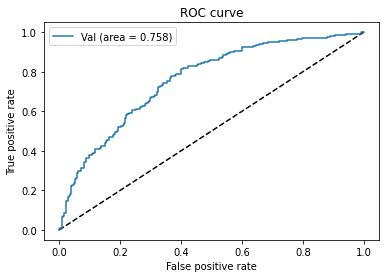

04/15/2022 16:13:59 - INFO - __main__ -   ***** Eval results *****
04/15/2022 16:13:59 - INFO - __main__ -     RP80 = 0.38022813688212925
04/15/2022 16:13:59 - INFO - __main__ -     eval_accuracy = 0.621760705752619
04/15/2022 16:13:59 - INFO - __main__ -     eval_loss = 0.6304757042277299
04/15/2022 16:13:59 - INFO - __main__ -     global_step = 0
04/15/2022 16:13:59 - INFO - __main__ -     training loss = 100000.0


Recall at Precision of 80 is {} 0.38022813688212925


<Figure size 432x288 with 0 Axes>

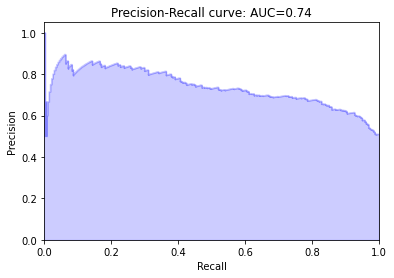

In [36]:
max_seq_length = 128
eval_batch_size = 2

m = nn.Sigmoid()
if do_eval:
    eval_examples = processor.get_test_examples(data_dir)
    eval_features = convert_examples_to_features(
        eval_examples, label_list, max_seq_length, tokenizer)
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_examples))
    logger.info("  Batch size = %d", eval_batch_size)
    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    if local_rank == -1:
        eval_sampler = SequentialSampler(eval_data)
    else:
        eval_sampler = DistributedSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    true_labels=[]
    pred_labels=[]
    logits_history=[]
    for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader):
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)
        with torch.no_grad():
            tmp_eval_loss, temp_logits = model(input_ids, segment_ids, input_mask, label_ids)
            logits = model(input_ids,segment_ids,input_mask)

        logits = torch.squeeze(m(logits)).detach().cpu().numpy()
        label_ids = label_ids.to('cpu').numpy()

        outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
        tmp_eval_accuracy=np.sum(outputs == label_ids)

        true_labels = true_labels + label_ids.flatten().tolist()
        pred_labels = pred_labels + outputs.flatten().tolist()
        logits_history = logits_history + logits.flatten().tolist()

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_examples
    df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})

    string = 'logits_clinicalbert_'+readmission_mode+'_chunks.csv'
    df.to_csv(os.path.join(output_dir, string))

    df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

    fpr, tpr, df_out = vote_score(df_test, logits_history, readmission_mode, output_dir)

    string = 'logits_clinicalbert_'+readmission_mode+'_readmissions.csv'
    df_out.to_csv(os.path.join(output_dir,string))

    rp80 = vote_pr_curve(df_test, logits_history, readmission_mode, output_dir)

    result = {'eval_loss': eval_loss,
              'eval_accuracy': eval_accuracy,                 
              'global_step': global_step_check,
              'training loss': train_loss/number_training_steps,
              'RP80': rp80}

    output_eval_file = os.path.join(output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results *****")
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

## Discharge Notes

### Run Model for Readmission Prediction

In [50]:
gradient_accumulation_steps = 1
if gradient_accumulation_steps < 1:
    raise ValueError("Invalid gradient_accumulation_steps parameter: {}, should be >= 1".format(gradient_accumulation_steps))

train_batch_size = 32
train_batch_size = int(train_batch_size / gradient_accumulation_steps)
seed= 42
do_train = False
do_eval = True
output_dir1 = './results/ablation/transformer/result_discharge' 

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

if not do_train and not do_eval:
    raise ValueError("At least one of `do_train` or `do_eval` must be True.")

if os.path.exists(output_dir1) and os.listdir(output_dir1):
    raise ValueError("Output directory ({}) already exists and is not empty.".format(output_dir1))

os.makedirs(output_dir1, exist_ok=True)

In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
data_dir = './data/discharge/'
train_examples = None
num_train_steps = None
if do_train:
    train_examples = processor.get_train_examples(data_dir)
    num_train_steps = int(
        len(train_examples) / train_batch_size / gradient_accumulation_steps * num_train_epochs)

### Prepare Model

In [33]:
sys.path.append('./')
bert_model='./model/discharge_readmission'
model = BertForSequenceClassification.from_pretrained(bert_model, 1)
model.to(device)

04/15/2022 21:16:14 - INFO - modeling_readmission -   loading archive file ./model/discharge_readmission
04/15/2022 21:16:14 - INFO - modeling_readmission -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
    

In [36]:
readmission_mode1 = 'discharge'

04/15/2022 21:19:30 - INFO - __main__ -   *** Example ***
04/15/2022 21:19:30 - INFO - __main__ -   guid: test-0
04/15/2022 21:19:30 - INFO - __main__ -   tokens: [CLS] date of birth : sex : f service : medicine all ##er ##gies : hal ##do ##l attending : chief complaint : delta ms , let ##har ##gy , ? sep ##sis . major surgical or invasive procedure : none history of present illness : h ##x obtained per ed notes and sister . hp ##i : 35 ##f with disease who presented today from day ##care after her healthcare providers noted that she was let ##har ##gic . they were initially unable to obtain a blood pressure . the patient was noted to have a very rapid heart rate . vital ##s were finally obtained and were as follows : bp 70 / 50 ( baseline sb ##ps 80 - 90 ) , hr 113 [SEP]
04/15/2022 21:19:30 - INFO - __main__ -   input_ids: 101 3058 1997 4182 1024 3348 1024 1042 2326 1024 4200 2035 2121 17252 1024 11085 3527 2140 7052 1024 2708 12087 1024 7160 5796 1010 2292 8167 6292 1010 1029 19802 6

04/15/2022 21:19:30 - INFO - __main__ -   *** Example ***
04/15/2022 21:19:30 - INFO - __main__ -   guid: test-4
04/15/2022 21:19:30 - INFO - __main__ -   tokens: [CLS] date of birth : sex : f service : medicine all ##er ##gies : pen ##ici ##llins / per ##co ##ce ##t attending : chief complaint : face , left arm and breast swelling major surgical or invasive procedure : intra ##ven ##ous cat ##het ##eri ##zation of sv ##c / iv ##c . history of present illness : 23 year old woman with es ##rd , sl ##e , recently placed pd cat ##het ##er who presents with per ##ior ##bit ##al swelling and hyper ##tens ##ive urgency . of note she was recently admitted for tongue swelling on . at that time she was treated with sol ##u - med ##rol , fa ##mot ##idi ##ne and ben ##ad ##ryl in the emergency room [SEP]
04/15/2022 21:19:30 - INFO - __main__ -   input_ids: 101 3058 1997 4182 1024 3348 1024 1042 2326 1024 4200 2035 2121 17252 1024 7279 28775 26655 1013 2566 3597 3401 2102 7052 1024 2708 12087 1024

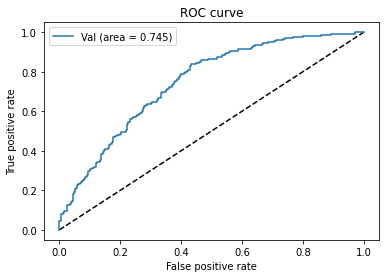

04/15/2022 21:46:57 - INFO - __main__ -   ***** Eval results *****
04/15/2022 21:46:57 - INFO - __main__ -     RP80 = 0.20689655172413793
04/15/2022 21:46:57 - INFO - __main__ -     eval_accuracy = 0.6304276852758733
04/15/2022 21:46:57 - INFO - __main__ -     eval_loss = 0.6483550992485515
04/15/2022 21:46:57 - INFO - __main__ -     global_step = 0
04/15/2022 21:46:57 - INFO - __main__ -     training loss = 100000.0


Recall at Precision of 80 is {} 0.20689655172413793


<Figure size 432x288 with 0 Axes>

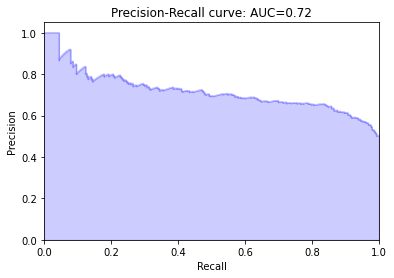

In [48]:
max_seq_length = 128
eval_batch_size = 2

m = nn.Sigmoid()
if do_eval:
    eval_examples = processor.get_test_examples(data_dir)
    eval_features = convert_examples_to_features(
        eval_examples, label_list, max_seq_length, tokenizer)
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_examples))
    logger.info("  Batch size = %d", eval_batch_size)
    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    if local_rank == -1:
        eval_sampler = SequentialSampler(eval_data)
    else:
        eval_sampler = DistributedSampler(eval_data)
    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    true_labels=[]
    pred_labels=[]
    logits_history=[]
    for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader):
        input_ids = input_ids.to(device)
        input_mask = input_mask.to(device)
        segment_ids = segment_ids.to(device)
        label_ids = label_ids.to(device)
        with torch.no_grad():
            tmp_eval_loss, temp_logits = model(input_ids, segment_ids, input_mask, label_ids)
            logits = model(input_ids,segment_ids,input_mask)

        logits = torch.squeeze(m(logits)).detach().cpu().numpy()
        label_ids = label_ids.to('cpu').numpy()

        outputs = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)])
        tmp_eval_accuracy=np.sum(outputs == label_ids)

        true_labels = true_labels + label_ids.flatten().tolist()
        pred_labels = pred_labels + outputs.flatten().tolist()
        logits_history = logits_history + logits.flatten().tolist()

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_examples
    df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})

    string = 'logits_clinicalbert_'+readmission_mode+'_chunks.csv'
    df.to_csv(os.path.join(output_dir1, string))

    df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

    fpr, tpr, df_out = vote_score(df_test, logits_history, readmission_mode, output_dir1)

    string = 'logits_clinicalbert_'+readmission_mode+'_readmissions.csv'
    df_out.to_csv(os.path.join(output_dir1,string))

    rp80 = vote_pr_curve(df_test, logits_history, readmission_mode, output_dir1)

    result = {'eval_loss': eval_loss,
              'eval_accuracy': eval_accuracy,                 
              'global_step': global_step_check,
              'training loss': train_loss/number_training_steps,
              'RP80': rp80}

    output_eval_file = os.path.join(output_dir1, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results *****")
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))